In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from aplpy import FITSFigure
from astropy.io.fits import PrimaryHDU
import astropy.units as u
from astropy.wcs import WCS

import matplotlib as mpl
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [173]:
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

### Calculate velocity axis

In [ ]:
def vel_axis(cb=None, hd=None):
    """
    Creates a velocity axis from given cube and header
    
    inputs:
    cb : 3D data cube, numpy.array object
    hd : header object
    
    output:
    vel_abs : array with velocities corresponding to the 3rd axis
    """
    
    pos = np.arange(cb.shape[0])         # position array for 3rd axis
    pos_rel = pos - hd['crpix3']         # relative from the central pixel
    vel_rel = pos_rel * hd['cdelt3']     # convert to relative velocities
    vel_abs = vel_rel + hd['crval3']     # actual velocity values
    
    if hd['cunit3'] == 'km s-1' 
        vel_abs = vel_abs * u.km/u.s          # velocities with unit


### make 2D header

In [85]:
def flatten_header(hd=None):
    """ 
    Flattens 3D header into 2D
    """
    hd2d = hd.copy()
    for key in hd2d.keys():
        if key.endswith('3'):
            hd2d.pop(key)
    hd2d['NAXIS'] = 2
    hd2d['WCSAXES'] = 2

    return hd2d

## channel maps

In [236]:
cb_13CO, hd_13CO = fits.getdata('../datacubes/spectral_slab_to_fit_13CO.fits', header=True)
cb_C18O, hd_C18O = fits.getdata('../datacubes/spectral_slab_to_fit_C18O.fits', header=True)

In [256]:
def plot_channel_maps(cb=None, hd=None, vmin=None, vmax=None, step=None, fig=None, ax=None, 
                      cmap='inferno', int_min=2, int_max=10, colourbar=False, 
                      colourbar_text=r'$\rm{K\ km\,s^{-1}}$', colourbar_loc='right',
                      beam=False, beam_colour='green', x_lbl=0.75, y_lbl=0.85, scalebar_corner='top right', 
                      background_grey=True, bckgr_gr_clr='0.8'):
    """
    inputs:
    cb : 3D cube, numpy.array object
    hd : header object
    
    vmin, vmax : velocity range for channel maps
    step : difference in velocity between channels
    
    fig, ax : matplotlib subplots
    """
    
    v_chan_arr = np.arange(vmin, vmax, step)                         # create array with the endpoints of the channels
    n_chan = v_chan_arr.shape[0] - 1                                 # number of channels
    v_chan_pos = np.zeros((n_chan, vel_axis.shape[0])).astype(bool)  # array with shape (no_of_chan, len_of_vel_ax)
    
    for i in range(n_chan):
        v1 = v_chan_arr[i]
        v2 = v_chan_arr[i + 1]
        vmid = np.round((v1 + v2)/2, 2)
        v_chan_pos[i] = (vel_axis.value>=v1) * (vel_axis.value<v2)   # mask velocities outside the corresponding channels


    ax_flat = ax.flatten()                                           # flatten axes to plot

    if background_grey:                                              # set background colour to the one given
        cmap = plt.get_cmap(cmap)
        cmap.set_bad(bckgr_gr_clr)
        
    for i in range(n_chan):
        plot_ax = ax_flat[i]

        slab_chan = cb_13CO[np.where(v_chan_pos[i])[0], :, :]        # slab corresponding to that channel
        sum_chan_i = np.nansum(slab_chan, axis=0) 
        mom0_chan_i = sum_chan_i * np.abs(hd['cdelt3'])              # moment 0 in that channel
        mom0_chan_i[mom0_chan_i == 0] = np.nan                       # mask NaNs
        plot_ax.imshow(mom0_chan_i, cmap=cmap, vmin=int_min, vmax=int_max)
        
        plot_ax.coords['ra'].set_major_formatter('hh:mm')
        
        vmid = np.round((v_chan_arr[i] + v_chan_arr[i + 1])/2, 2)
        plot_ax.text(x_lbl, y_lbl, str(vmid) + '\n' + r'$\rm{km\,s^{-1}}$', transform=plot_ax.transAxes)

    nrows = ax.shape[0]
    ncols = ax.shape[1]
    for i in range(nrows):                                           # remove 
        for j in range(ncols):
            if i != nrows-1 :
                ax[i,j].xaxis.label.set_visible(False)
                ax[i,j].tick_params(axis='x', labelbottom=False)
            else :
                ax[i,j].set_xlabel('RA (J2000)')
            if j!= 0 :
                ax[i,j].yaxis.label.set_visible(False)
                ax[i,j].tick_params(axis='y', labelleft=False)
            else:
                ax[i,j].set_ylabel('Dec (J2000)')
                
    if colourbar:
        norm = mcolors.Normalize(vmin=int_min, vmax=int_max)
        sm = ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])  # Dummy array for colorbar
        
        if colourbar_loc == 'right':
            clrbar_ax = fig.add_axes([1.02, 0.2, 0.02, 0.7])
            clrbar = fig.colorbar(sm, cax=clrbar_ax, orientation='vertical', fraction=0.015, pad=0.01)
            clrbar.set_label(colourbar_text)
        
                
    return fig, ax

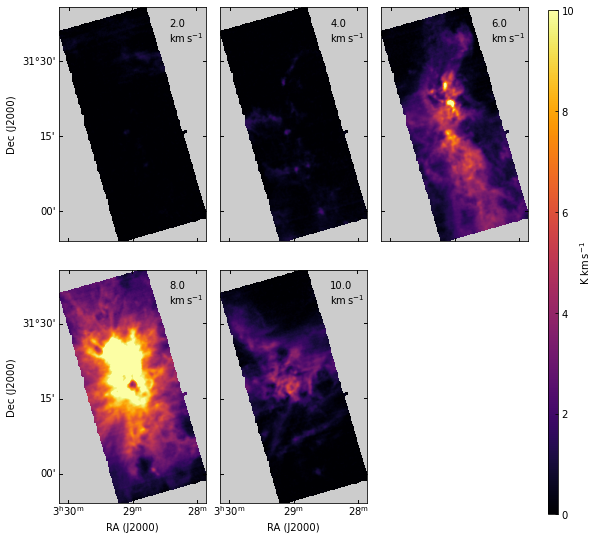

In [258]:
fig, ax = plt.subplots(ncols=3, nrows=2, gridspec_kw={'hspace': -0.2, 'wspace' : 0.1, 'left':0.05, 
                                                      'right':0.98,'top':0.97,'bottom':0.15}, figsize=(7, 10),
                     subplot_kw=dict(projection=wcs))

fig, ax = plot_channel_maps(cb=cb_13CO, hd=hd_13CO, vmin=1, vmax=12, step=2, fig=fig, ax=ax, 
                            int_min=0, int_max=10, colourbar=True)

ax[-1, -1].set_visible(False)

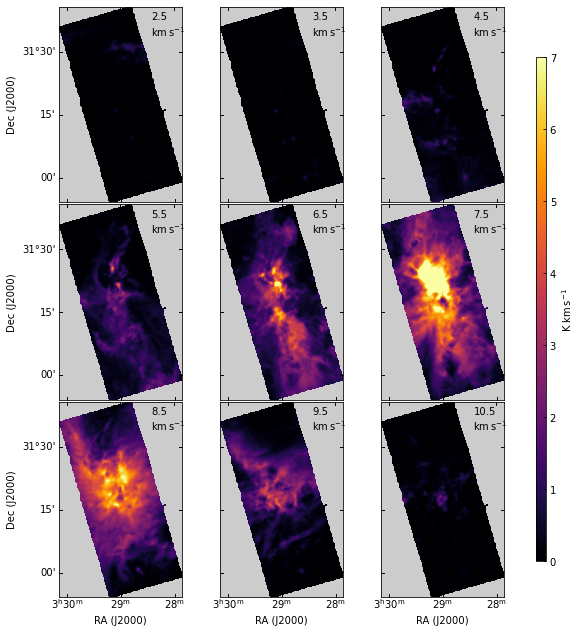

In [271]:
fig, ax = plt.subplots(ncols=3, nrows=3, gridspec_kw={'hspace': 0.01, 'wspace' : 0.1, 'left':0.05, 
                                                      'right':0.98,'top':0.97,'bottom':0.15}, figsize=(7, 10),
                     subplot_kw=dict(projection=wcs))

fig, ax = plot_channel_maps(cb=cb_13CO, hd=hd_13CO, vmin=2, vmax=12, step=1, fig=fig, ax=ax, 
                            int_min=0, int_max=7, colourbar=True)

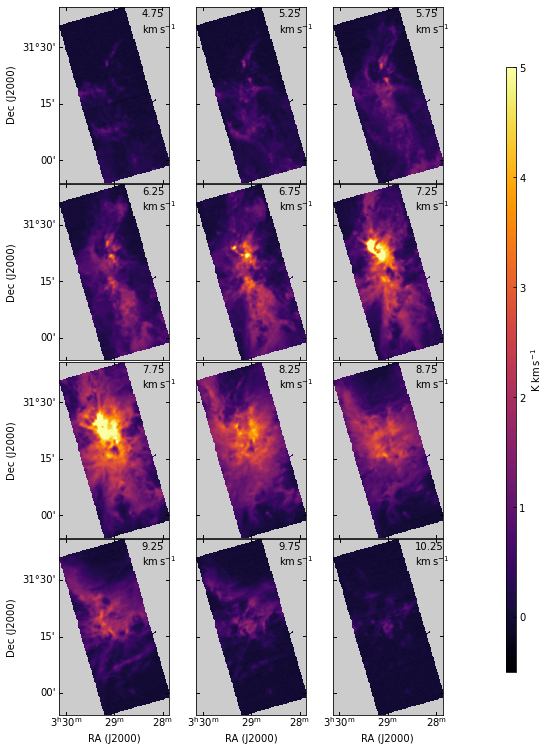

In [277]:
fig, ax = plt.subplots(ncols=3, nrows=4, gridspec_kw={'hspace': 0.01, 'wspace' : -0.3, 'left':0.05, 
                                                      'right':0.98,'top':0.97,'bottom':0.15}, figsize=(7, 12),
                     subplot_kw=dict(projection=wcs))

fig, ax = plot_channel_maps(cb=cb_13CO, hd=hd_13CO, vmin=4.5, vmax=11, step=0.5, fig=fig, ax=ax, 
                            int_min=-0.5, int_max=5, colourbar=True)


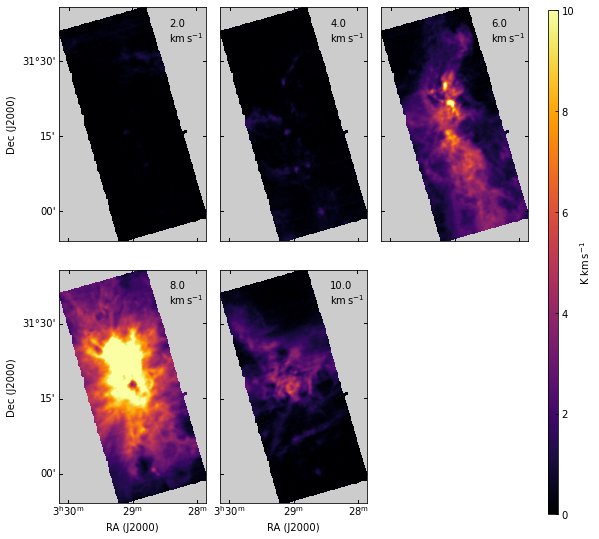

In [280]:
fig, ax = plt.subplots(ncols=3, nrows=2, gridspec_kw={'hspace': -0.2, 'wspace' : 0.1, 'left':0.05, 
                                                      'right':0.98,'top':0.97,'bottom':0.15}, figsize=(7, 10),
                     subplot_kw=dict(projection=wcs))

fig, ax = plot_channel_maps(cb=cb_C18O, hd=hd_C18O, vmin=1, vmax=12, step=2, fig=fig, ax=ax, 
                            int_min=0, int_max=10, colourbar=True)

ax[-1, -1].set_visible(False)

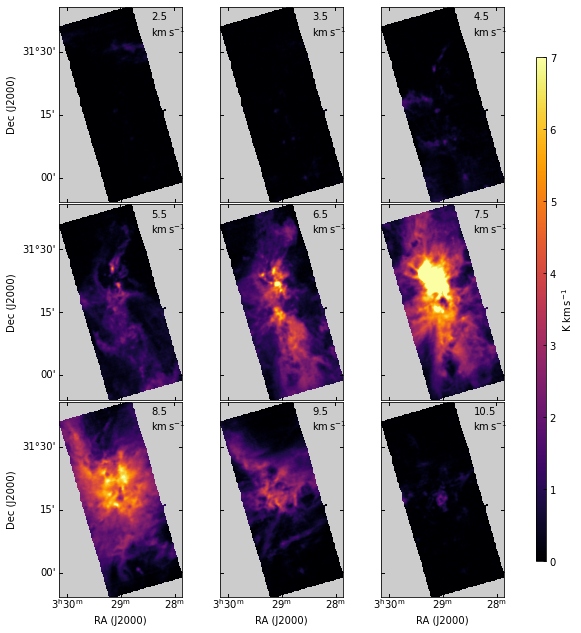

In [281]:
fig, ax = plt.subplots(ncols=3, nrows=3, gridspec_kw={'hspace': 0.01, 'wspace' : 0.1, 'left':0.05, 
                                                      'right':0.98,'top':0.97,'bottom':0.15}, figsize=(7, 10),
                     subplot_kw=dict(projection=wcs))

fig, ax = plot_channel_maps(cb=cb_C18O, hd=hd_C18O, vmin=2, vmax=12, step=1, fig=fig, ax=ax, 
                            int_min=0, int_max=7, colourbar=True)

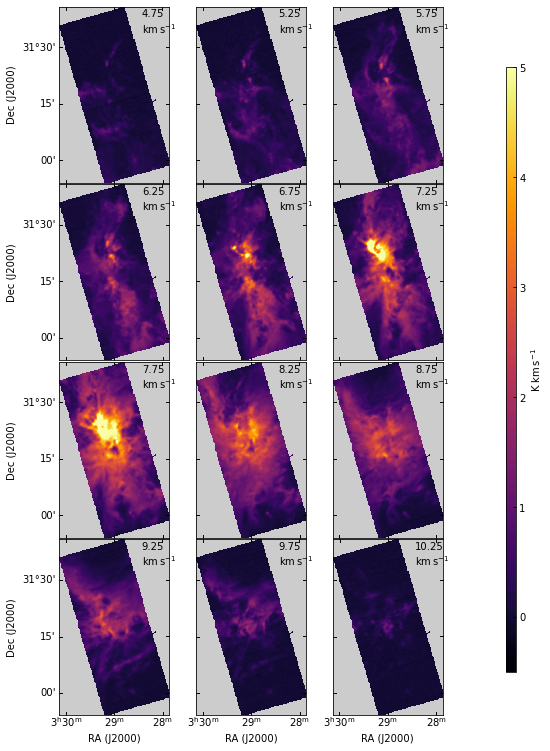

In [282]:
fig, ax = plt.subplots(ncols=3, nrows=4, gridspec_kw={'hspace': 0.01, 'wspace' : -0.3, 'left':0.05, 
                                                      'right':0.98,'top':0.97,'bottom':0.15}, figsize=(7, 12),
                     subplot_kw=dict(projection=wcs))

fig, ax = plot_channel_maps(cb=cb_C18O, hd=hd_C18O, vmin=4.5, vmax=11, step=0.5, fig=fig, ax=ax, 
                            int_min=-0.5, int_max=5, colourbar=True)
